In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

- https://www.youtube.com/watch?v=HTN6rccMu1k

In [2]:
import numpy as np
import pandas as pd
import torch
from utils import evaluate
from sklearn.metrics import roc_curve

In [224]:
df = pd.read_csv('./data/pima_indians_diabetes_database.csv', dtype={'Outcome': 'category'})
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df.describe()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))

mask = np.triu(np.ones_like(df.corr()))
dataplot = sns.heatmap(df.corr(), annot=True, fmt='.2f', mask=mask, cmap="RdYlGn", vmin=-1, vmax=1)

In [ ]:
columns_to_impute = df[[col for col in df.columns if col not in {'Outcome'}]].applymap(lambda x: x == 0).sum().reset_index()
columns_to_impute['percent'] = columns_to_impute[0] / df.shape[0]
columns_to_impute

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=0, strategy='mean')
columns_to_impute = [index for (index, value) in df[[col for col in df.columns if col not in {'Outcome', 'Pregnancies'}]].applymap(lambda x: x == 0).sum().items() if value > 0]
for col in columns_to_impute:
    df[col] = imputer.fit_transform(df[[col]]).ravel()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))

mask = np.triu(np.ones_like(df.corr()))
dataplot = sns.heatmap(df.corr(), annot=True, fmt='.2f', mask=mask, cmap="RdYlGn", vmin=-1, vmax=1)

In [ ]:
import plotly.figure_factory as ff
fig = ff.create_scatterplotmatrix(df, diag='histogram', index='Outcome', size=3, title='Diabetes progression data', height=1200, width=2400)
fig.show()

In [ ]:
import plotly.express as px
fig = px.pie(df, names='Outcome', title='Outcomes', width=800, labels={'0':'Negative','1':'Positive'})
fig.update_layout(legend_title_text='Developed diabetes')
for i, val in enumerate(fig.data[0].labels):
    if val == '0':
        fig.data[0].labels[i] = 'No'
    else:
        fig.data[0].labels[i] = 'Yes'
fig.show()

# Data pre-processing

In [157]:
from load_data import load_pima_indians_diabetes_database
columns, (x_raw_train, y_raw_train), (x_raw_val, y_raw_val), (x_raw_test, y_raw_test) = load_pima_indians_diabetes_database()
print('COLUMNS: ', columns)
print('training set: ', x_raw_train.shape, y_raw_train.shape)
print('validation set: ', x_raw_val.shape, y_raw_val.shape)
print('test set: ', x_raw_test.shape, y_raw_test.shape)

COLUMNS:  ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
training set:  (462, 8) (462, 1)
validation set:  (153, 8) (153, 1)
test set:  (153, 8) (153, 1)


In [4]:
task = 'binary_classification'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = int(np.ceil(x_train.shape[0] / 100))
print(f'device is {device} and batch size is {batch_size}')

device is cpu and batch size is 5


In [159]:
from preprocessor import Preprocessor

preprocessor = Preprocessor(task=task, n_quantiles=x_train.shape[0])
x_train, y_train = preprocessor.fit_transform(x_raw_train, y_raw_train)
x_val, y_val = preprocessor.transform(x_raw_val, y_raw_val)
x_test, y_test = preprocessor.transform(x_raw_test, y_raw_test)

In [7]:
x_train_val = np.concatenate((x_train, x_val))
y_train_val = np.concatenate((y_train, y_val))

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
def get_confusion_matrix(y_pred):
    confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues, display_labels=['Non-diabetic', 'Diabetic'])
    (precision, recall, f_score, support) = precision_recall_fscore_support(y_test, y_pred, average='binary')
    print(f"precision={precision:.7f} recall={recall:.7f} f_score={f_score:.7f} support={support}")
    return confusion_matrix

In [9]:
def get_lr_local_interpretation(index, feature_weights):
    x = x_test[index]
    feature_influence = x * feature_weights
    zeros = np.zeros(8)
    x_mean = preprocessor.inverse_transform_x([zeros])[0]
    x_true = preprocessor.inverse_transform_x([x])[0]
    df = pd.DataFrame(np.stack([x, x_true, x_mean, feature_weights, feature_influence]), columns= columns).T.reset_index()
    df.columns = ['variable', 'scaled', 'original', 'mean_values', 'feature_weights', 'feature_contribution']
    return df

In [292]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_local_interpretation(df, title, range1=[-3,3], range2=[-5.5,5.5]):
    df['variable_val'] = df.apply(lambda r: f"{r['variable']} ({int(r['original']) if r['original'].is_integer() else round(r['original'], 2)})", axis=1)
    
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=("Feature contribution", "Values of features relative to the mean"))

    fig.add_trace(go.Bar(x=df['feature_contribution'], y=df['variable'], orientation='h', text=df['variable'], showlegend=False, marker={'color':'#1f77b4'}), row=1, col=1)
    fig.add_trace(go.Bar(x=df['scaled'], y=df['variable'], orientation='h', text=df['variable_val'], showlegend=False, marker={'color':['#1f77b4' for i in range(10)] + ['#bcbd22', '#2ca02c']}),row=1, col=2)
    if 'feature_weights' in df.columns:
        fig.add_trace(go.Bar(x=df['feature_weights'], y=df['variable'], orientation='h', showlegend=False, marker={'color':'#17becf'}),row=1, col=2)

    fig.update_layout(title_text=title, height=800)
    fig.update_yaxes(visible=False, showticklabels=False)
    fig['layout']['xaxis1'].update(range=range1, showgrid=False)
    fig['layout']['xaxis2'].update(range=range2, showgrid=False)
    fig['layout'].update(barmode='relative')

    return fig

## Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(x_train, y_train.ravel())
lr_fit = lr.predict_proba(x_train)[:, 1]
lr_pred = lr.predict_proba(x_test)[:, 1]

print('TRAIN: ', evaluate(y_train, lr_fit, task))
print('TEST: ', evaluate(y_test, lr_pred, task))
lr_weights = pd.DataFrame([(col, coefficient) for col, coefficient in zip(columns, lr.coef_[-1])], columns=['variable', 'coefficient'])
lr_weights.sort_values(by='coefficient', key=abs, ascending=False)

TRAIN:  (0.8507872309692329, 0.7333367741049902)
TEST:  (0.82430426716141, 0.7255794408589363)


,variable,coefficient
1,Glucose,1.130468
5,BMI,0.687990
7,Age,0.508550
6,DiabetesPedigreeFunction,0.325458
0,Pregnancies,0.307318
3,SkinThickness,0.091333
4,Insulin,0.043568
2,BloodPressure,-0.010742


In [40]:
import plotly.express as px
fig = px.bar(lr_weights, y='variable', x='coefficient', orientation='h', range_x=(-1.25, 1.25), text='variable', title='Global feature importance for Linear Regression', height=800, width=800, labels={'coefficient': 'feature importance'})
fig.update_yaxes(visible=False, showticklabels=False)
fig.update_xaxes(showgrid=False)
fig.show()

In [41]:
lr_local = get_lr_local_interpretation(147, lr.coef_[-1])
fig = plot_local_interpretation(lr_local, f'Local interpretation of Logistic Regression for a TRUE NEGATIVE | P(y=1) = {lr_pred[147]:.4f}')
fig.show()

In [42]:
lr_local = get_lr_local_interpretation(73, lr.coef_[-1])
fig = plot_local_interpretation(lr_local, f'Local interpretation of Logistic Regression for a FALSE NEGATIVE | P(y=1) = {lr_pred[73]:.4f}')
fig.show()

In [43]:
lr_local = get_lr_local_interpretation(36, lr.coef_[-1])
fig = plot_local_interpretation(lr_local, f'Local interpretation of Logistic Regression for a TRUE POSITIVE | P(y=1) = {lr_pred[36]:.4f}')
fig.show()

In [44]:
lr_local = get_lr_local_interpretation(49, lr.coef_[-1])
fig = plot_local_interpretation(lr_local, f'Local interpretation of Logistic Regression for a FALSE POSITIVE | P(y=1) = {lr_pred[49]:.4f}')
fig.show()

In [154]:
y_r = np.concatenate((y_test, nam_pred.reshape(-1,1)), axis=1)

In [139]:
sure_negative = np.where((y_r[:,1]<=np.percentile(y_r[:,1], 5, method='closest_observation')) & (y_r[:,0] == 0))
print(sure_negative)
y_r[sure_negative]

(array([  2,   6,  40,  54, 101, 139, 147]),)


array([[0.        , 0.00027047],
       [0.        , 0.00026675],
       [0.        , 0.00035545],
       [0.        , 0.00036245],
       [0.        , 0.00028223],
       [0.        , 0.00031491],
       [0.        , 0.00021608]])

In [140]:
sure_false_negative = np.where((y_r[:,1]<=np.percentile(y_r[:,1], 5, method='closest_observation')) & (y_r[:,0] == 1))
print(sure_false_negative)
y_r[sure_false_negative]

(array([63]),)


array([[1.00000000e+00, 3.43908476e-04]])

In [143]:
sure_false_positive = np.where((y_r[:,1]>=np.percentile(y_r[:,1], 99, method='closest_observation')) & (y_r[:,0] == 0))
print(sure_false_positive)
y_r[sure_false_positive]

(array([65]),)


array([[0.        , 0.00111931]])

In [144]:
sure_positive = np.where((y_r[:,1]>=np.percentile(y_r[:,1], 99, method='closest_observation')) & (y_r[:,0] == 1))
print(sure_positive)
y_r[sure_positive]

(array([ 30, 122]),)


array([[1.        , 0.00106727],
       [1.        , 0.00117777]])

## CrossNet
[deepctr-torch](https://deepctr-torch.readthedocs.io/en/latest/index.html)

In [271]:
from deepctr_torch.inputs import DenseFeat
from deepctr_torch.models import DCN

feature_columns = [DenseFeat(col, 1) for col in columns]

train_model_input = dict(zip(columns, x_train.T))
val_model_input = dict(zip(columns, x_val.T))
test_model_input = dict(zip(columns, x_test.T))
    
dcn = DCN(linear_feature_columns=feature_columns, dnn_feature_columns=feature_columns, dnn_hidden_units=[16, 32, 16], task='binary', device=device, l2_reg_embedding=1e-02, l2_reg_cross=1e-02, l2_reg_dnn=0.5, dnn_dropout=0.5)
dcn.compile("adam", "mse", metrics=['mse'])
history = dcn.fit(train_model_input, y_train, validation_data=(val_model_input, y_val), epochs=300)

cpu
Train on 462 samples, validate on 153 samples, 2 steps per epoch


2it [00:00, 123.29it/s]


Epoch 1/300
0s - loss:  0.2771 - mse:  0.2769 - val_mse:  0.2700


2it [00:00, 121.42it/s]


Epoch 2/300
0s - loss:  0.2751 - mse:  0.2745 - val_mse:  0.2677


2it [00:00, 124.29it/s]


Epoch 3/300
0s - loss:  0.2726 - mse:  0.2722 - val_mse:  0.2655


2it [00:00, 119.50it/s]


Epoch 4/300
0s - loss:  0.2701 - mse:  0.2702 - val_mse:  0.2632


2it [00:00, 119.47it/s]


Epoch 5/300
0s - loss:  0.2676 - mse:  0.2664 - val_mse:  0.2609


2it [00:00, 128.95it/s]


Epoch 6/300
0s - loss:  0.2652 - mse:  0.2655 - val_mse:  0.2586


2it [00:00, 106.63it/s]


Epoch 7/300
0s - loss:  0.2626 - mse:  0.2625 - val_mse:  0.2563


2it [00:00, 107.22it/s]


Epoch 8/300
0s - loss:  0.2602 - mse:  0.2591 - val_mse:  0.2541


2it [00:00, 136.88it/s]


Epoch 9/300
0s - loss:  0.2577 - mse:  0.2572 - val_mse:  0.2518


2it [00:00, 152.31it/s]


Epoch 10/300
0s - loss:  0.2554 - mse:  0.2534 - val_mse:  0.2495


2it [00:00, 120.47it/s]


Epoch 11/300
0s - loss:  0.2528 - mse:  0.2514 - val_mse:  0.2473


2it [00:00, 122.24it/s]


Epoch 12/300
0s - loss:  0.2503 - mse:  0.2493 - val_mse:  0.2451


2it [00:00, 105.30it/s]


Epoch 13/300
0s - loss:  0.2480 - mse:  0.2464 - val_mse:  0.2429


2it [00:00, 110.13it/s]


Epoch 14/300
0s - loss:  0.2457 - mse:  0.2448 - val_mse:  0.2409


2it [00:00, 118.14it/s]


Epoch 15/300
0s - loss:  0.2436 - mse:  0.2425 - val_mse:  0.2388


2it [00:00, 102.28it/s]


Epoch 16/300
0s - loss:  0.2414 - mse:  0.2413 - val_mse:  0.2367


2it [00:00, 99.50it/s]


Epoch 17/300
0s - loss:  0.2392 - mse:  0.2382 - val_mse:  0.2346


2it [00:00, 110.95it/s]


Epoch 18/300
0s - loss:  0.2369 - mse:  0.2354 - val_mse:  0.2324


2it [00:00, 101.27it/s]


Epoch 19/300
0s - loss:  0.2347 - mse:  0.2331 - val_mse:  0.2301


2it [00:00, 88.89it/s]


Epoch 20/300
0s - loss:  0.2324 - mse:  0.2304 - val_mse:  0.2278


2it [00:00, 100.59it/s]


Epoch 21/300
0s - loss:  0.2301 - mse:  0.2286 - val_mse:  0.2256


2it [00:00, 106.51it/s]


Epoch 22/300
0s - loss:  0.2276 - mse:  0.2256 - val_mse:  0.2232


2it [00:00, 105.69it/s]


Epoch 23/300
0s - loss:  0.2252 - mse:  0.2233 - val_mse:  0.2209


2it [00:00, 106.61it/s]


Epoch 24/300
0s - loss:  0.2226 - mse:  0.2206 - val_mse:  0.2185


2it [00:00, 104.99it/s]


Epoch 25/300
0s - loss:  0.2201 - mse:  0.2182 - val_mse:  0.2161


2it [00:00, 116.45it/s]


Epoch 26/300
0s - loss:  0.2177 - mse:  0.2138 - val_mse:  0.2137


2it [00:00, 106.99it/s]


Epoch 27/300
0s - loss:  0.2153 - mse:  0.2120 - val_mse:  0.2114


2it [00:00, 112.54it/s]


Epoch 28/300
0s - loss:  0.2128 - mse:  0.2097 - val_mse:  0.2090


2it [00:00, 147.71it/s]


Epoch 29/300
0s - loss:  0.2104 - mse:  0.2074 - val_mse:  0.2067


2it [00:00, 112.98it/s]


Epoch 30/300
0s - loss:  0.2080 - mse:  0.2040 - val_mse:  0.2045


2it [00:00, 121.61it/s]


Epoch 31/300
0s - loss:  0.2056 - mse:  0.2003 - val_mse:  0.2024


2it [00:00, 115.94it/s]


Epoch 32/300
0s - loss:  0.2036 - mse:  0.1999 - val_mse:  0.2004


2it [00:00, 111.59it/s]


Epoch 33/300
0s - loss:  0.2014 - mse:  0.1964 - val_mse:  0.1984


2it [00:00, 105.05it/s]


Epoch 34/300
0s - loss:  0.1995 - mse:  0.1942 - val_mse:  0.1967


2it [00:00, 117.99it/s]


Epoch 35/300
0s - loss:  0.1977 - mse:  0.1926 - val_mse:  0.1951


2it [00:00, 107.16it/s]


Epoch 36/300
0s - loss:  0.1960 - mse:  0.1898 - val_mse:  0.1936


2it [00:00, 112.50it/s]


Epoch 37/300
0s - loss:  0.1945 - mse:  0.1883 - val_mse:  0.1922


2it [00:00, 121.46it/s]


Epoch 38/300
0s - loss:  0.1933 - mse:  0.1879 - val_mse:  0.1910


2it [00:00, 100.71it/s]


Epoch 39/300
0s - loss:  0.1922 - mse:  0.1876 - val_mse:  0.1899


2it [00:00, 113.76it/s]


Epoch 40/300
0s - loss:  0.1911 - mse:  0.1851 - val_mse:  0.1888


2it [00:00, 113.84it/s]


Epoch 41/300
0s - loss:  0.1900 - mse:  0.1832 - val_mse:  0.1878


2it [00:00, 125.93it/s]


Epoch 42/300
0s - loss:  0.1891 - mse:  0.1818 - val_mse:  0.1869


2it [00:00, 108.70it/s]


Epoch 43/300
0s - loss:  0.1882 - mse:  0.1796 - val_mse:  0.1860


2it [00:00, 120.51it/s]


Epoch 44/300
0s - loss:  0.1874 - mse:  0.1791 - val_mse:  0.1851


2it [00:00, 117.67it/s]


Epoch 45/300
0s - loss:  0.1867 - mse:  0.1802 - val_mse:  0.1842


2it [00:00, 111.30it/s]


Epoch 46/300
0s - loss:  0.1860 - mse:  0.1784 - val_mse:  0.1834


2it [00:00, 108.45it/s]


Epoch 47/300
0s - loss:  0.1851 - mse:  0.1778 - val_mse:  0.1826


2it [00:00, 118.98it/s]


Epoch 48/300
0s - loss:  0.1845 - mse:  0.1763 - val_mse:  0.1817


2it [00:00, 97.66it/s]


Epoch 49/300
0s - loss:  0.1837 - mse:  0.1767 - val_mse:  0.1810


2it [00:00, 103.09it/s]


Epoch 50/300
0s - loss:  0.1830 - mse:  0.1752 - val_mse:  0.1802


2it [00:00, 116.18it/s]


Epoch 51/300
0s - loss:  0.1823 - mse:  0.1740 - val_mse:  0.1794


2it [00:00, 95.65it/s]


Epoch 52/300
0s - loss:  0.1816 - mse:  0.1743 - val_mse:  0.1787


2it [00:00, 117.97it/s]


Epoch 53/300
0s - loss:  0.1810 - mse:  0.1724 - val_mse:  0.1780


2it [00:00, 118.07it/s]


Epoch 54/300
0s - loss:  0.1804 - mse:  0.1718 - val_mse:  0.1773


2it [00:00, 110.40it/s]


Epoch 55/300
0s - loss:  0.1797 - mse:  0.1703 - val_mse:  0.1766


2it [00:00, 110.99it/s]


Epoch 56/300
0s - loss:  0.1792 - mse:  0.1711 - val_mse:  0.1759


2it [00:00, 120.97it/s]


Epoch 57/300
0s - loss:  0.1786 - mse:  0.1696 - val_mse:  0.1753


2it [00:00, 123.69it/s]


Epoch 58/300
0s - loss:  0.1780 - mse:  0.1699 - val_mse:  0.1747


2it [00:00, 84.41it/s]


Epoch 59/300
0s - loss:  0.1776 - mse:  0.1681 - val_mse:  0.1740


2it [00:00, 118.46it/s]


Epoch 60/300
0s - loss:  0.1770 - mse:  0.1695 - val_mse:  0.1734


2it [00:00, 114.96it/s]


Epoch 61/300
0s - loss:  0.1766 - mse:  0.1680 - val_mse:  0.1729


2it [00:00, 121.70it/s]


Epoch 62/300
0s - loss:  0.1761 - mse:  0.1667 - val_mse:  0.1723


2it [00:00, 114.57it/s]


Epoch 63/300
0s - loss:  0.1757 - mse:  0.1689 - val_mse:  0.1718


2it [00:00, 112.59it/s]


Epoch 64/300
0s - loss:  0.1752 - mse:  0.1668 - val_mse:  0.1713


2it [00:00, 100.42it/s]


Epoch 65/300
0s - loss:  0.1749 - mse:  0.1666 - val_mse:  0.1709


2it [00:00, 100.83it/s]


Epoch 66/300
0s - loss:  0.1744 - mse:  0.1662 - val_mse:  0.1704


2it [00:00, 113.86it/s]


Epoch 67/300
0s - loss:  0.1741 - mse:  0.1646 - val_mse:  0.1700


2it [00:00, 105.87it/s]


Epoch 68/300
0s - loss:  0.1737 - mse:  0.1663 - val_mse:  0.1695


2it [00:00, 100.39it/s]


Epoch 69/300
0s - loss:  0.1733 - mse:  0.1633 - val_mse:  0.1691


2it [00:00, 88.83it/s]


Epoch 70/300
0s - loss:  0.1730 - mse:  0.1638 - val_mse:  0.1687


2it [00:00, 103.12it/s]


Epoch 71/300
0s - loss:  0.1726 - mse:  0.1646 - val_mse:  0.1683


2it [00:00, 111.76it/s]


Epoch 72/300
0s - loss:  0.1723 - mse:  0.1635 - val_mse:  0.1679


2it [00:00, 94.53it/s]


Epoch 73/300
0s - loss:  0.1720 - mse:  0.1643 - val_mse:  0.1675


2it [00:00, 109.59it/s]


Epoch 74/300
0s - loss:  0.1717 - mse:  0.1632 - val_mse:  0.1672


2it [00:00, 110.34it/s]


Epoch 75/300
0s - loss:  0.1714 - mse:  0.1623 - val_mse:  0.1669


2it [00:00, 106.28it/s]


Epoch 76/300
0s - loss:  0.1711 - mse:  0.1625 - val_mse:  0.1665


2it [00:00, 113.19it/s]


Epoch 77/300
0s - loss:  0.1708 - mse:  0.1619 - val_mse:  0.1662


2it [00:00, 100.58it/s]


Epoch 78/300
0s - loss:  0.1706 - mse:  0.1621 - val_mse:  0.1659


2it [00:00, 110.02it/s]


Epoch 79/300
0s - loss:  0.1703 - mse:  0.1616 - val_mse:  0.1656


2it [00:00, 123.06it/s]


Epoch 80/300
0s - loss:  0.1700 - mse:  0.1621 - val_mse:  0.1653


2it [00:00, 97.02it/s]


Epoch 81/300
0s - loss:  0.1698 - mse:  0.1623 - val_mse:  0.1650


2it [00:00, 91.63it/s]


Epoch 82/300
0s - loss:  0.1695 - mse:  0.1606 - val_mse:  0.1647


2it [00:00, 93.59it/s]


Epoch 83/300
0s - loss:  0.1693 - mse:  0.1614 - val_mse:  0.1644


2it [00:00, 100.14it/s]


Epoch 84/300
0s - loss:  0.1690 - mse:  0.1597 - val_mse:  0.1642


2it [00:00, 104.81it/s]


Epoch 85/300
0s - loss:  0.1688 - mse:  0.1613 - val_mse:  0.1639


2it [00:00, 86.11it/s]


Epoch 86/300
0s - loss:  0.1686 - mse:  0.1603 - val_mse:  0.1637


2it [00:00, 105.66it/s]


Epoch 87/300
0s - loss:  0.1684 - mse:  0.1596 - val_mse:  0.1634


2it [00:00, 103.15it/s]


Epoch 88/300
0s - loss:  0.1681 - mse:  0.1584 - val_mse:  0.1632


2it [00:00, 46.09it/s]


Epoch 89/300
0s - loss:  0.1679 - mse:  0.1593 - val_mse:  0.1629


2it [00:00, 102.02it/s]


Epoch 90/300
0s - loss:  0.1677 - mse:  0.1610 - val_mse:  0.1627


2it [00:00, 111.12it/s]


Epoch 91/300
0s - loss:  0.1675 - mse:  0.1598 - val_mse:  0.1625


2it [00:00, 94.48it/s]


Epoch 92/300
0s - loss:  0.1673 - mse:  0.1586 - val_mse:  0.1623


2it [00:00, 111.58it/s]


Epoch 93/300
0s - loss:  0.1671 - mse:  0.1595 - val_mse:  0.1621


2it [00:00, 95.44it/s]


Epoch 94/300
0s - loss:  0.1669 - mse:  0.1579 - val_mse:  0.1619


2it [00:00, 98.57it/s]


Epoch 95/300
0s - loss:  0.1668 - mse:  0.1575 - val_mse:  0.1616


2it [00:00, 98.46it/s]


Epoch 96/300
0s - loss:  0.1666 - mse:  0.1599 - val_mse:  0.1614


2it [00:00, 102.28it/s]


Epoch 97/300
0s - loss:  0.1664 - mse:  0.1569 - val_mse:  0.1612


2it [00:00, 87.53it/s]


Epoch 98/300
0s - loss:  0.1662 - mse:  0.1572 - val_mse:  0.1610


2it [00:00, 116.37it/s]


Epoch 99/300
0s - loss:  0.1660 - mse:  0.1582 - val_mse:  0.1609


2it [00:00, 98.69it/s]


Epoch 100/300
0s - loss:  0.1658 - mse:  0.1565 - val_mse:  0.1607


2it [00:00, 99.48it/s]


Epoch 101/300
0s - loss:  0.1657 - mse:  0.1565 - val_mse:  0.1605


2it [00:00, 109.24it/s]


Epoch 102/300
0s - loss:  0.1654 - mse:  0.1566 - val_mse:  0.1603


2it [00:00, 99.26it/s]


Epoch 103/300
0s - loss:  0.1653 - mse:  0.1591 - val_mse:  0.1601


2it [00:00, 112.05it/s]


Epoch 104/300
0s - loss:  0.1650 - mse:  0.1566 - val_mse:  0.1600


2it [00:00, 92.06it/s]


Epoch 105/300
0s - loss:  0.1647 - mse:  0.1559 - val_mse:  0.1598


2it [00:00, 103.80it/s]


Epoch 106/300
0s - loss:  0.1643 - mse:  0.1569 - val_mse:  0.1597


2it [00:00, 94.22it/s]


Epoch 107/300
0s - loss:  0.1638 - mse:  0.1563 - val_mse:  0.1596


2it [00:00, 107.61it/s]


Epoch 108/300
0s - loss:  0.1631 - mse:  0.1558 - val_mse:  0.1595


2it [00:00, 93.66it/s]


Epoch 109/300
0s - loss:  0.1629 - mse:  0.1544 - val_mse:  0.1594


2it [00:00, 105.37it/s]


Epoch 110/300
0s - loss:  0.1627 - mse:  0.1543 - val_mse:  0.1593


2it [00:00, 117.07it/s]


Epoch 111/300
0s - loss:  0.1626 - mse:  0.1550 - val_mse:  0.1592


2it [00:00, 118.69it/s]


Epoch 112/300
0s - loss:  0.1624 - mse:  0.1543 - val_mse:  0.1591


2it [00:00, 104.84it/s]


Epoch 113/300
0s - loss:  0.1623 - mse:  0.1548 - val_mse:  0.1590


2it [00:00, 103.04it/s]


Epoch 114/300
0s - loss:  0.1622 - mse:  0.1533 - val_mse:  0.1588


2it [00:00, 115.23it/s]


Epoch 115/300
0s - loss:  0.1622 - mse:  0.1535 - val_mse:  0.1587


2it [00:00, 128.30it/s]


Epoch 116/300
0s - loss:  0.1620 - mse:  0.1537 - val_mse:  0.1585


2it [00:00, 109.11it/s]


Epoch 117/300
0s - loss:  0.1619 - mse:  0.1532 - val_mse:  0.1584


2it [00:00, 122.90it/s]


Epoch 118/300
0s - loss:  0.1618 - mse:  0.1550 - val_mse:  0.1582


2it [00:00, 123.92it/s]


Epoch 119/300
0s - loss:  0.1617 - mse:  0.1528 - val_mse:  0.1581


2it [00:00, 99.21it/s]


Epoch 120/300
0s - loss:  0.1616 - mse:  0.1519 - val_mse:  0.1579


2it [00:00, 101.77it/s]


Epoch 121/300
0s - loss:  0.1615 - mse:  0.1521 - val_mse:  0.1578


2it [00:00, 101.77it/s]


Epoch 122/300
0s - loss:  0.1614 - mse:  0.1540 - val_mse:  0.1577


2it [00:00, 111.30it/s]


Epoch 123/300
0s - loss:  0.1613 - mse:  0.1543 - val_mse:  0.1575


2it [00:00, 102.66it/s]


Epoch 124/300
0s - loss:  0.1612 - mse:  0.1533 - val_mse:  0.1573


2it [00:00, 102.07it/s]


Epoch 125/300
0s - loss:  0.1611 - mse:  0.1528 - val_mse:  0.1572


2it [00:00, 113.19it/s]


Epoch 126/300
0s - loss:  0.1610 - mse:  0.1522 - val_mse:  0.1571


2it [00:00, 92.80it/s]


Epoch 127/300
0s - loss:  0.1609 - mse:  0.1525 - val_mse:  0.1569


2it [00:00, 100.44it/s]


Epoch 128/300
0s - loss:  0.1608 - mse:  0.1529 - val_mse:  0.1568


2it [00:00, 105.13it/s]


Epoch 129/300
0s - loss:  0.1607 - mse:  0.1533 - val_mse:  0.1567


2it [00:00, 101.16it/s]


Epoch 130/300
0s - loss:  0.1606 - mse:  0.1547 - val_mse:  0.1565


2it [00:00, 115.68it/s]


Epoch 131/300
0s - loss:  0.1605 - mse:  0.1523 - val_mse:  0.1564


2it [00:00, 99.91it/s]


Epoch 132/300
0s - loss:  0.1604 - mse:  0.1529 - val_mse:  0.1563


2it [00:00, 85.56it/s]


Epoch 133/300
0s - loss:  0.1603 - mse:  0.1527 - val_mse:  0.1562


2it [00:00, 100.48it/s]


Epoch 134/300
0s - loss:  0.1603 - mse:  0.1510 - val_mse:  0.1561


2it [00:00, 97.63it/s]


Epoch 135/300
0s - loss:  0.1602 - mse:  0.1522 - val_mse:  0.1559


2it [00:00, 94.97it/s]


Epoch 136/300
0s - loss:  0.1601 - mse:  0.1518 - val_mse:  0.1559


2it [00:00, 95.05it/s]


Epoch 137/300
0s - loss:  0.1600 - mse:  0.1513 - val_mse:  0.1558


2it [00:00, 109.57it/s]


Epoch 138/300
0s - loss:  0.1600 - mse:  0.1514 - val_mse:  0.1557


2it [00:00, 117.67it/s]


Epoch 139/300
0s - loss:  0.1599 - mse:  0.1528 - val_mse:  0.1556


2it [00:00, 99.78it/s]


Epoch 140/300
0s - loss:  0.1598 - mse:  0.1527 - val_mse:  0.1555


2it [00:00, 99.76it/s]


Epoch 141/300
0s - loss:  0.1598 - mse:  0.1526 - val_mse:  0.1554


2it [00:00, 90.50it/s]


Epoch 142/300
0s - loss:  0.1597 - mse:  0.1509 - val_mse:  0.1553


2it [00:00, 104.85it/s]


Epoch 143/300
0s - loss:  0.1596 - mse:  0.1511 - val_mse:  0.1552


2it [00:00, 106.94it/s]


Epoch 144/300
0s - loss:  0.1595 - mse:  0.1528 - val_mse:  0.1551


2it [00:00, 90.21it/s]


Epoch 145/300
0s - loss:  0.1595 - mse:  0.1524 - val_mse:  0.1550


2it [00:00, 92.35it/s]


Epoch 146/300
0s - loss:  0.1594 - mse:  0.1505 - val_mse:  0.1549


2it [00:00, 101.56it/s]


Epoch 147/300
0s - loss:  0.1593 - mse:  0.1506 - val_mse:  0.1549


2it [00:00, 105.01it/s]


Epoch 148/300
0s - loss:  0.1593 - mse:  0.1512 - val_mse:  0.1548


2it [00:00, 104.42it/s]


Epoch 149/300
0s - loss:  0.1592 - mse:  0.1517 - val_mse:  0.1547


2it [00:00, 98.40it/s]


Epoch 150/300
0s - loss:  0.1591 - mse:  0.1523 - val_mse:  0.1546


2it [00:00, 113.51it/s]


Epoch 151/300
0s - loss:  0.1591 - mse:  0.1515 - val_mse:  0.1545


2it [00:00, 106.87it/s]


Epoch 152/300
0s - loss:  0.1590 - mse:  0.1516 - val_mse:  0.1544


2it [00:00, 99.54it/s]


Epoch 153/300
0s - loss:  0.1590 - mse:  0.1497 - val_mse:  0.1543


2it [00:00, 94.57it/s]


Epoch 154/300
0s - loss:  0.1589 - mse:  0.1497 - val_mse:  0.1543


2it [00:00, 96.00it/s]


Epoch 155/300
0s - loss:  0.1588 - mse:  0.1498 - val_mse:  0.1542


2it [00:00, 101.05it/s]


Epoch 156/300
0s - loss:  0.1588 - mse:  0.1521 - val_mse:  0.1541


2it [00:00, 102.56it/s]


Epoch 157/300
0s - loss:  0.1587 - mse:  0.1505 - val_mse:  0.1540


2it [00:00, 98.25it/s]


Epoch 158/300
0s - loss:  0.1587 - mse:  0.1513 - val_mse:  0.1540


2it [00:00, 96.22it/s]


Epoch 159/300
0s - loss:  0.1586 - mse:  0.1506 - val_mse:  0.1539


2it [00:00, 102.63it/s]


Epoch 160/300
0s - loss:  0.1585 - mse:  0.1500 - val_mse:  0.1538


2it [00:00, 102.90it/s]


Epoch 161/300
0s - loss:  0.1585 - mse:  0.1499 - val_mse:  0.1538


2it [00:00, 100.68it/s]


Epoch 162/300
0s - loss:  0.1584 - mse:  0.1521 - val_mse:  0.1537


2it [00:00, 83.12it/s]


Epoch 163/300
0s - loss:  0.1583 - mse:  0.1516 - val_mse:  0.1536


2it [00:00, 88.15it/s]


Epoch 164/300
0s - loss:  0.1583 - mse:  0.1495 - val_mse:  0.1535


2it [00:00, 114.57it/s]


Epoch 165/300
0s - loss:  0.1582 - mse:  0.1496 - val_mse:  0.1535


2it [00:00, 84.76it/s]


Epoch 166/300
0s - loss:  0.1581 - mse:  0.1511 - val_mse:  0.1534


2it [00:00, 91.00it/s]


Epoch 167/300
0s - loss:  0.1581 - mse:  0.1516 - val_mse:  0.1533


2it [00:00, 92.01it/s]


Epoch 168/300
0s - loss:  0.1580 - mse:  0.1500 - val_mse:  0.1533


2it [00:00, 100.71it/s]


Epoch 169/300
0s - loss:  0.1579 - mse:  0.1489 - val_mse:  0.1532


2it [00:00, 106.76it/s]


Epoch 170/300
0s - loss:  0.1579 - mse:  0.1511 - val_mse:  0.1531


2it [00:00, 96.57it/s]


Epoch 171/300
0s - loss:  0.1578 - mse:  0.1496 - val_mse:  0.1530


2it [00:00, 101.32it/s]


Epoch 172/300
0s - loss:  0.1577 - mse:  0.1496 - val_mse:  0.1530


2it [00:00, 102.19it/s]


Epoch 173/300
0s - loss:  0.1577 - mse:  0.1501 - val_mse:  0.1529


2it [00:00, 97.64it/s]


Epoch 174/300
0s - loss:  0.1576 - mse:  0.1492 - val_mse:  0.1528


2it [00:00, 98.36it/s]


Epoch 175/300
0s - loss:  0.1576 - mse:  0.1490 - val_mse:  0.1528


2it [00:00, 91.70it/s]


Epoch 176/300
0s - loss:  0.1575 - mse:  0.1492 - val_mse:  0.1527


2it [00:00, 87.70it/s]


Epoch 177/300
0s - loss:  0.1574 - mse:  0.1505 - val_mse:  0.1526


2it [00:00, 100.22it/s]


Epoch 178/300
0s - loss:  0.1574 - mse:  0.1504 - val_mse:  0.1526


2it [00:00, 99.23it/s]


Epoch 179/300
0s - loss:  0.1573 - mse:  0.1498 - val_mse:  0.1525


2it [00:00, 97.23it/s]


Epoch 180/300
0s - loss:  0.1573 - mse:  0.1503 - val_mse:  0.1524


2it [00:00, 44.66it/s]


Epoch 181/300
0s - loss:  0.1572 - mse:  0.1492 - val_mse:  0.1524


2it [00:00, 107.00it/s]


Epoch 182/300
0s - loss:  0.1571 - mse:  0.1494 - val_mse:  0.1523


2it [00:00, 102.93it/s]


Epoch 183/300
0s - loss:  0.1571 - mse:  0.1481 - val_mse:  0.1522


2it [00:00, 93.76it/s]


Epoch 184/300
0s - loss:  0.1570 - mse:  0.1498 - val_mse:  0.1522


2it [00:00, 95.57it/s]


Epoch 185/300
0s - loss:  0.1569 - mse:  0.1494 - val_mse:  0.1521


2it [00:00, 97.79it/s]


Epoch 186/300
0s - loss:  0.1569 - mse:  0.1502 - val_mse:  0.1520


2it [00:00, 95.68it/s]


Epoch 187/300
0s - loss:  0.1568 - mse:  0.1486 - val_mse:  0.1520


2it [00:00, 101.87it/s]


Epoch 188/300
0s - loss:  0.1567 - mse:  0.1498 - val_mse:  0.1519


2it [00:00, 88.24it/s]


Epoch 189/300
0s - loss:  0.1567 - mse:  0.1488 - val_mse:  0.1518


2it [00:00, 98.25it/s]


Epoch 190/300
0s - loss:  0.1566 - mse:  0.1492 - val_mse:  0.1518


2it [00:00, 98.57it/s]


Epoch 191/300
0s - loss:  0.1565 - mse:  0.1491 - val_mse:  0.1517


2it [00:00, 90.59it/s]


Epoch 192/300
0s - loss:  0.1565 - mse:  0.1493 - val_mse:  0.1516


2it [00:00, 109.75it/s]


Epoch 193/300
0s - loss:  0.1564 - mse:  0.1482 - val_mse:  0.1516


2it [00:00, 95.29it/s]


Epoch 194/300
0s - loss:  0.1564 - mse:  0.1489 - val_mse:  0.1515


2it [00:00, 92.94it/s]


Epoch 195/300
0s - loss:  0.1563 - mse:  0.1482 - val_mse:  0.1514


2it [00:00, 112.13it/s]


Epoch 196/300
0s - loss:  0.1562 - mse:  0.1503 - val_mse:  0.1513


2it [00:00, 91.91it/s]


Epoch 197/300
0s - loss:  0.1562 - mse:  0.1473 - val_mse:  0.1513


2it [00:00, 103.15it/s]


Epoch 198/300
0s - loss:  0.1561 - mse:  0.1486 - val_mse:  0.1512


2it [00:00, 102.90it/s]


Epoch 199/300
0s - loss:  0.1560 - mse:  0.1499 - val_mse:  0.1511


2it [00:00, 79.20it/s]


Epoch 200/300
0s - loss:  0.1560 - mse:  0.1478 - val_mse:  0.1511


2it [00:00, 80.61it/s]


Epoch 201/300
0s - loss:  0.1559 - mse:  0.1485 - val_mse:  0.1510


2it [00:00, 89.45it/s]


Epoch 202/300
0s - loss:  0.1558 - mse:  0.1486 - val_mse:  0.1509


2it [00:00, 90.88it/s]


Epoch 203/300
0s - loss:  0.1559 - mse:  0.1471 - val_mse:  0.1509


2it [00:00, 96.55it/s]


Epoch 204/300
0s - loss:  0.1557 - mse:  0.1475 - val_mse:  0.1508


2it [00:00, 90.74it/s]


Epoch 205/300
0s - loss:  0.1556 - mse:  0.1490 - val_mse:  0.1508


2it [00:00, 92.06it/s]


Epoch 206/300
0s - loss:  0.1556 - mse:  0.1489 - val_mse:  0.1507


2it [00:00, 85.42it/s]


Epoch 207/300
0s - loss:  0.1556 - mse:  0.1483 - val_mse:  0.1506


2it [00:00, 86.73it/s]


Epoch 208/300
0s - loss:  0.1555 - mse:  0.1483 - val_mse:  0.1505


2it [00:00, 105.33it/s]


Epoch 209/300
0s - loss:  0.1554 - mse:  0.1474 - val_mse:  0.1505


2it [00:00, 98.46it/s]


Epoch 210/300
0s - loss:  0.1553 - mse:  0.1477 - val_mse:  0.1504


2it [00:00, 116.35it/s]


Epoch 211/300
0s - loss:  0.1552 - mse:  0.1498 - val_mse:  0.1504


2it [00:00, 87.88it/s]


Epoch 212/300
0s - loss:  0.1552 - mse:  0.1473 - val_mse:  0.1503


2it [00:00, 101.24it/s]


Epoch 213/300
0s - loss:  0.1551 - mse:  0.1477 - val_mse:  0.1502


2it [00:00, 109.06it/s]


Epoch 214/300
0s - loss:  0.1551 - mse:  0.1467 - val_mse:  0.1502


2it [00:00, 89.72it/s]


Epoch 215/300
0s - loss:  0.1550 - mse:  0.1490 - val_mse:  0.1501


2it [00:00, 105.42it/s]


Epoch 216/300
0s - loss:  0.1549 - mse:  0.1494 - val_mse:  0.1500


2it [00:00, 96.31it/s]


Epoch 217/300
0s - loss:  0.1548 - mse:  0.1464 - val_mse:  0.1500


2it [00:00, 91.99it/s]


Epoch 218/300
0s - loss:  0.1548 - mse:  0.1490 - val_mse:  0.1499


2it [00:00, 93.87it/s]


Epoch 219/300
0s - loss:  0.1547 - mse:  0.1460 - val_mse:  0.1498


2it [00:00, 105.08it/s]


Epoch 220/300
0s - loss:  0.1546 - mse:  0.1479 - val_mse:  0.1498


2it [00:00, 91.65it/s]


Epoch 221/300
0s - loss:  0.1546 - mse:  0.1484 - val_mse:  0.1497


2it [00:00, 96.54it/s]


Epoch 222/300
0s - loss:  0.1545 - mse:  0.1481 - val_mse:  0.1496


2it [00:00, 97.56it/s]


Epoch 223/300
0s - loss:  0.1544 - mse:  0.1464 - val_mse:  0.1495


2it [00:00, 104.60it/s]


Epoch 224/300
0s - loss:  0.1544 - mse:  0.1464 - val_mse:  0.1495


2it [00:00, 108.32it/s]


Epoch 225/300
0s - loss:  0.1543 - mse:  0.1474 - val_mse:  0.1494


2it [00:00, 93.07it/s]


Epoch 226/300
0s - loss:  0.1543 - mse:  0.1472 - val_mse:  0.1494


2it [00:00, 89.25it/s]


Epoch 227/300
0s - loss:  0.1542 - mse:  0.1472 - val_mse:  0.1493


2it [00:00, 94.35it/s]


Epoch 228/300
0s - loss:  0.1541 - mse:  0.1460 - val_mse:  0.1492


2it [00:00, 99.98it/s]


Epoch 229/300
0s - loss:  0.1541 - mse:  0.1478 - val_mse:  0.1492


2it [00:00, 90.09it/s]


Epoch 230/300
0s - loss:  0.1540 - mse:  0.1455 - val_mse:  0.1491


2it [00:00, 101.35it/s]


Epoch 231/300
0s - loss:  0.1539 - mse:  0.1469 - val_mse:  0.1490


2it [00:00, 93.25it/s]


Epoch 232/300
0s - loss:  0.1539 - mse:  0.1476 - val_mse:  0.1490


2it [00:00, 111.91it/s]


Epoch 233/300
0s - loss:  0.1538 - mse:  0.1459 - val_mse:  0.1489


2it [00:00, 97.57it/s]


Epoch 234/300
0s - loss:  0.1538 - mse:  0.1456 - val_mse:  0.1489


2it [00:00, 104.78it/s]


Epoch 235/300
0s - loss:  0.1536 - mse:  0.1471 - val_mse:  0.1488


2it [00:00, 103.42it/s]


Epoch 236/300
0s - loss:  0.1536 - mse:  0.1461 - val_mse:  0.1487


2it [00:00, 89.47it/s]


Epoch 237/300
0s - loss:  0.1535 - mse:  0.1451 - val_mse:  0.1486


2it [00:00, 101.38it/s]


Epoch 238/300
0s - loss:  0.1535 - mse:  0.1477 - val_mse:  0.1486


2it [00:00, 90.69it/s]


Epoch 239/300
0s - loss:  0.1534 - mse:  0.1460 - val_mse:  0.1485


2it [00:00, 100.50it/s]


Epoch 240/300
0s - loss:  0.1534 - mse:  0.1474 - val_mse:  0.1484


2it [00:00, 92.84it/s]


Epoch 241/300
0s - loss:  0.1533 - mse:  0.1450 - val_mse:  0.1484


2it [00:00, 96.28it/s]


Epoch 242/300
0s - loss:  0.1532 - mse:  0.1446 - val_mse:  0.1483


2it [00:00, 116.52it/s]


Epoch 243/300
0s - loss:  0.1531 - mse:  0.1489 - val_mse:  0.1482


2it [00:00, 100.77it/s]


Epoch 244/300
0s - loss:  0.1531 - mse:  0.1455 - val_mse:  0.1482


2it [00:00, 92.48it/s]


Epoch 245/300
0s - loss:  0.1530 - mse:  0.1456 - val_mse:  0.1481


2it [00:00, 94.68it/s]


Epoch 246/300
0s - loss:  0.1529 - mse:  0.1463 - val_mse:  0.1481


2it [00:00, 90.02it/s]


Epoch 247/300
0s - loss:  0.1529 - mse:  0.1464 - val_mse:  0.1480


2it [00:00, 83.64it/s]


Epoch 248/300
0s - loss:  0.1528 - mse:  0.1462 - val_mse:  0.1479


2it [00:00, 98.86it/s]


Epoch 249/300
0s - loss:  0.1527 - mse:  0.1457 - val_mse:  0.1479


2it [00:00, 92.10it/s]


Epoch 250/300
0s - loss:  0.1527 - mse:  0.1454 - val_mse:  0.1478


2it [00:00, 84.10it/s]


Epoch 251/300
0s - loss:  0.1526 - mse:  0.1456 - val_mse:  0.1478


2it [00:00, 88.13it/s]


Epoch 252/300
0s - loss:  0.1526 - mse:  0.1461 - val_mse:  0.1477


2it [00:00, 85.84it/s]


Epoch 253/300
0s - loss:  0.1525 - mse:  0.1453 - val_mse:  0.1477


2it [00:00, 91.82it/s]


Epoch 254/300
0s - loss:  0.1524 - mse:  0.1458 - val_mse:  0.1476


2it [00:00, 90.50it/s]


Epoch 255/300
0s - loss:  0.1524 - mse:  0.1453 - val_mse:  0.1476


2it [00:00, 91.42it/s]


Epoch 256/300
0s - loss:  0.1523 - mse:  0.1449 - val_mse:  0.1475


2it [00:00, 97.88it/s]


Epoch 257/300
0s - loss:  0.1523 - mse:  0.1457 - val_mse:  0.1475


2it [00:00, 89.75it/s]


Epoch 258/300
0s - loss:  0.1523 - mse:  0.1443 - val_mse:  0.1475


2it [00:00, 93.70it/s]


Epoch 259/300
0s - loss:  0.1521 - mse:  0.1441 - val_mse:  0.1474


2it [00:00, 92.41it/s]


Epoch 260/300
0s - loss:  0.1521 - mse:  0.1459 - val_mse:  0.1474


2it [00:00, 95.33it/s]


Epoch 261/300
0s - loss:  0.1520 - mse:  0.1447 - val_mse:  0.1473


2it [00:00, 102.42it/s]


Epoch 262/300
0s - loss:  0.1520 - mse:  0.1454 - val_mse:  0.1473


2it [00:00, 111.86it/s]


Epoch 263/300
0s - loss:  0.1519 - mse:  0.1445 - val_mse:  0.1472


2it [00:00, 101.95it/s]


Epoch 264/300
0s - loss:  0.1518 - mse:  0.1449 - val_mse:  0.1472


2it [00:00, 96.81it/s]


Epoch 265/300
0s - loss:  0.1518 - mse:  0.1436 - val_mse:  0.1472


2it [00:00, 89.73it/s]


Epoch 266/300
0s - loss:  0.1517 - mse:  0.1458 - val_mse:  0.1471


2it [00:00, 92.16it/s]


Epoch 267/300
0s - loss:  0.1517 - mse:  0.1446 - val_mse:  0.1471


2it [00:00, 98.38it/s]


Epoch 268/300
0s - loss:  0.1516 - mse:  0.1438 - val_mse:  0.1470


2it [00:00, 93.20it/s]


Epoch 269/300
0s - loss:  0.1515 - mse:  0.1450 - val_mse:  0.1470


2it [00:00, 90.07it/s]


Epoch 270/300
0s - loss:  0.1515 - mse:  0.1440 - val_mse:  0.1470


2it [00:00, 81.47it/s]


Epoch 271/300
0s - loss:  0.1514 - mse:  0.1452 - val_mse:  0.1470


2it [00:00, 87.42it/s]


Epoch 272/300
0s - loss:  0.1514 - mse:  0.1449 - val_mse:  0.1469


2it [00:00, 83.47it/s]


Epoch 273/300
0s - loss:  0.1513 - mse:  0.1439 - val_mse:  0.1469


2it [00:00, 77.18it/s]


Epoch 274/300
0s - loss:  0.1513 - mse:  0.1434 - val_mse:  0.1468


2it [00:00, 93.33it/s]


Epoch 275/300
0s - loss:  0.1512 - mse:  0.1432 - val_mse:  0.1468


2it [00:00, 100.30it/s]


Epoch 276/300
0s - loss:  0.1511 - mse:  0.1430 - val_mse:  0.1468


2it [00:00, 85.75it/s]


Epoch 277/300
0s - loss:  0.1511 - mse:  0.1461 - val_mse:  0.1467


2it [00:00, 99.16it/s]


Epoch 278/300
0s - loss:  0.1510 - mse:  0.1434 - val_mse:  0.1467


2it [00:00, 102.81it/s]


Epoch 279/300
0s - loss:  0.1510 - mse:  0.1434 - val_mse:  0.1467


2it [00:00, 83.30it/s]


Epoch 280/300
0s - loss:  0.1509 - mse:  0.1445 - val_mse:  0.1467


2it [00:00, 90.11it/s]


Epoch 281/300
0s - loss:  0.1509 - mse:  0.1438 - val_mse:  0.1467


2it [00:00, 94.03it/s]


Epoch 282/300
0s - loss:  0.1508 - mse:  0.1423 - val_mse:  0.1467


2it [00:00, 87.06it/s]


Epoch 283/300
0s - loss:  0.1508 - mse:  0.1438 - val_mse:  0.1467


2it [00:00, 95.41it/s]


Epoch 284/300
0s - loss:  0.1507 - mse:  0.1427 - val_mse:  0.1466


2it [00:00, 92.59it/s]


Epoch 285/300
0s - loss:  0.1507 - mse:  0.1441 - val_mse:  0.1466


2it [00:00, 88.87it/s]


Epoch 286/300
0s - loss:  0.1506 - mse:  0.1426 - val_mse:  0.1466


2it [00:00, 79.10it/s]


Epoch 287/300
0s - loss:  0.1507 - mse:  0.1425 - val_mse:  0.1465


2it [00:00, 109.79it/s]


Epoch 288/300
0s - loss:  0.1505 - mse:  0.1436 - val_mse:  0.1465


2it [00:00, 100.16it/s]


Epoch 289/300
0s - loss:  0.1505 - mse:  0.1433 - val_mse:  0.1465


2it [00:00, 98.56it/s]


Epoch 290/300
0s - loss:  0.1504 - mse:  0.1409 - val_mse:  0.1465


2it [00:00, 82.39it/s]


Epoch 291/300
0s - loss:  0.1504 - mse:  0.1441 - val_mse:  0.1465


2it [00:00, 87.55it/s]


Epoch 292/300
0s - loss:  0.1503 - mse:  0.1422 - val_mse:  0.1466


2it [00:00, 85.34it/s]


Epoch 293/300
0s - loss:  0.1503 - mse:  0.1421 - val_mse:  0.1466


2it [00:00, 73.59it/s]


Epoch 294/300
0s - loss:  0.1502 - mse:  0.1432 - val_mse:  0.1466


2it [00:00, 87.31it/s]


Epoch 295/300
0s - loss:  0.1502 - mse:  0.1441 - val_mse:  0.1465


2it [00:00, 77.68it/s]


Epoch 296/300
0s - loss:  0.1501 - mse:  0.1438 - val_mse:  0.1464


2it [00:00, 101.26it/s]


Epoch 297/300
0s - loss:  0.1501 - mse:  0.1425 - val_mse:  0.1464


2it [00:00, 99.63it/s]


Epoch 298/300
0s - loss:  0.1500 - mse:  0.1430 - val_mse:  0.1464


2it [00:00, 96.02it/s]


Epoch 299/300
0s - loss:  0.1500 - mse:  0.1407 - val_mse:  0.1464


2it [00:00, 97.96it/s]


Epoch 300/300
0s - loss:  0.1500 - mse:  0.1448 - val_mse:  0.1464


In [263]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_mse'])

In [265]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=[_ for _ in range(0, len(history.history['loss']))], y=history.history['loss'], mode='lines', name='loss'))
# fig.add_trace(go.Scatter(x=range(0, len(history.history['mse'])), y=history.history['mse'], mode='lines', name='mse'))
# fig.add_trace(go.Scatter(x=range(0, len(history.history['val_mse'])), y=history.history['val_mse'], mode='lines', name='val_mse'))
fig.show()

In [268]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=[_ for _ in range(0, len(history.history['mse']))], y=history.history['mse'], mode='lines', name='mse'))
fig.add_trace(go.Scatter(x=[_ for _ in range(0, len(history.history['val_mse']))], y=history.history['val_mse'], mode='lines', name='val_mse'))
fig.show()

In [272]:
print("TRAIN: ", evaluate(y_train, dcn.predict(train_model_input), task))
print("VAL: ", evaluate(y_val, dcn.predict(val_model_input), task))
print("TEST: ", evaluate(y_test, dcn.predict(test_model_input), task))

TRAIN:  (0.8638404510807142, 0.729585361990471)
VAL:  (0.8628497790868925, 0.7772454583629381)
TEST:  (0.7970315398886828, 0.6456264252616418)


## Multi Layer Perceptron

In [46]:
from sklearn.neural_network import MLPClassifier
# {'alpha': 1e-05, 'learning_rate_init': 0.001, 'tol': 0.001}
mlp = MLPClassifier(hidden_layer_sizes=(32,64,32), batch_size=batch_size, learning_rate='adaptive', learning_rate_init=0.001, max_iter=1000, early_stopping=True, validation_fraction=0.2, tol=0.001, alpha=0.0001)
mlp.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)).ravel())

MLPClassifier(batch_size=5, early_stopping=True,
              hidden_layer_sizes=(32, 64, 32), learning_rate='adaptive',
              max_iter=1000, tol=0.001, validation_fraction=0.2)

In [47]:
print("TRAIN: ", evaluate(y_train, mlp.predict_proba(x_train)[:, 1], task))
print("VAL: ", evaluate(y_val, mlp.predict_proba(x_val)[:, 1], task))
print("TEST: ", evaluate(y_test, mlp.predict_proba(x_test)[:, 1], task))

TRAIN:  (0.8406347372113658, 0.722144863168474)
VAL:  (0.8187357197258187, 0.6666310075918968)
TEST:  (0.8250463821892393, 0.7488397290745712)


## XGBoost
[dlmc](https://xgboost.readthedocs.io/en/stable/index.html)

In [68]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=1500, learning_rate=0.2, gamma=7, max_depth=5, objective='binary:logistic', eval_metric='auc')
xgb.fit(x_train, y_train)

print("TRAIN: ", evaluate(y_train, xgb.predict_proba(x_train)[:, 1], task))
print("VAL: ", evaluate(y_val, xgb.predict_proba(x_val)[:, 1], task))
print("TEST: ", evaluate(y_test, xgb.predict_proba(x_test)[:, 1], task))
xgb_df = pd.DataFrame([(col, coefficient) for col, coefficient in zip(columns, xgb.feature_importances_)], columns=['variable', 'feature_importance'])
xgb_df.set_index(['variable']).sort_values(by=['feature_importance'], ascending=False)

TRAIN:  (0.9082354883308227, 0.8327388506713209)
VAL:  (0.8562452399086062, 0.7290467322149355)
TEST:  (0.8179035250463822, 0.7019104584836081)


,feature_importance
variable,
Glucose,0.292643
Age,0.190525
BMI,0.163421
Insulin,0.124847
SkinThickness,0.119359
DiabetesPedigreeFunction,0.109205
Pregnancies,0.000000
BloodPressure,0.000000


In [70]:
import plotly.express as px
fig = px.bar(xgb_df, y='variable', x='feature_importance', orientation='h', range_x=(0, 0.3), text='variable', title='Global feature importance for XGBoost', height=800, width=800, labels={'feature_importance': 'feature importance'})
fig.update_yaxes(visible=False, showticklabels=False)
fig.update_xaxes(showgrid=False)
fig.show()

## Explainable Boosting Machine
[interpret.ml](https://interpret.ml/docs/ebm.html#)

In [77]:
from interpret.glassbox import ExplainableBoostingClassifier
ebm = ExplainableBoostingClassifier(feature_names=columns, outer_bags=10, inner_bags=10, learning_rate=0.01, max_rounds=30_000, validation_size=0.2)
ebm.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))
ebm_pred = ebm.predict(x_test)

print("TRAIN: ", evaluate(y_train, ebm.predict_proba(x_train)[:, 1], task))
print("VAL: ", evaluate(y_val, ebm.predict_proba(x_val)[:, 1], task))
print("TEST: ", evaluate(y_test, ebm.predict_proba(x_test)[:, 1], task))

TRAIN:  (0.9298611254410762, 0.8844129025877225)
VAL:  (0.9160319878141661, 0.8520509141927979)
TEST:  (0.8220779220779221, 0.7007637001093265)


In [82]:
ebm.term_scores_[0]

array([ 0.        , -0.09269658, -0.17079215, -0.15676629,  0.02275333,
       -0.04033797,  0.02380875,  0.05552687,  0.31378604,  0.43101274,
        0.43140703,  0.0601892 ,  0.00102267, -0.12600152, -0.01682109,
        0.9252708 ,  0.94365845,  0.        ])

In [85]:
from interpret import show
show(ebm.explain_global(name='Global feature importance for Explainable Boosting Classifier'))

<!-- http://127.0.0.1:7001/140250614814512/ -->

In [86]:
show(ebm.explain_local(x_test[[147, 73, 36, 49]], y_test[[147, 73, 36, 49]], name='Local interpretation of Explainable Boosting Classifier'), 0)

<!-- http://127.0.0.1:7001/140250656169072/ -->

## NAM (**NOT WORKING)
- [google-research/neural_additive_models](https://github.com/google-research/google-research/tree/master/neural_additive_models)
- [emeln/nam](https://github.com/lemeln/nam)

In [116]:
from nam.wrapper import NAMClassifier
nam = NAMClassifier(num_epochs=18_000, num_learners=95, metric='auroc', early_stop_mode='max', monitor_loss=True, n_jobs=-1, val_split=0.2)
nam.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)).ravel())

2023-06-10 00:48:12.691732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 00:48:12.691852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 00:48:12.692203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [117]:
print("TRAIN: ", evaluate(y_train, nam.predict_proba(x_train), task))
print("VAL: ", evaluate(y_val, nam.predict_proba(x_val), task))

nam_pred = nam.predict_proba(x_test)
print("TEST: ", evaluate(y_test, nam_pred, task))

TRAIN:  (0.7484987928437301, 0.5544605533214246)
VAL:  (0.7408606245239908, 0.5597022827895576)
TEST:  (0.7738404452690166, 0.66519501080771)


In [156]:
nam.predict_proba(x_test)

array([0.00051121, 0.00043791, 0.00032742, 0.00078414, 0.0006896 ,
       0.00051342, 0.00026166, 0.00063601, 0.0005515 , 0.00069132,
       0.00072761, 0.00113058, 0.00070585, 0.00055819, 0.00045312,
       0.00068504, 0.00049404, 0.00065473, 0.00106633, 0.000376  ,
       0.00061808, 0.00059759, 0.00057916, 0.00032729, 0.00091695,
       0.00095695, 0.00044785, 0.00025734, 0.00040402, 0.00034524,
       0.00118885, 0.00094297, 0.00070808, 0.00090866, 0.00062838,
       0.00079558, 0.00078301, 0.00067682, 0.00064781, 0.00069458,
       0.00031692, 0.00069141, 0.00049759, 0.00043561, 0.00043559,
       0.00082906, 0.00094823, 0.00063888, 0.00042122, 0.00080917,
       0.00027853, 0.00081095, 0.0007949 , 0.00068559, 0.00051113,
       0.00033098, 0.00075442, 0.00047566, 0.0006025 , 0.00068779,
       0.00065877, 0.00054822, 0.00031539, 0.00051047, 0.0006301 ,
       0.00070308, 0.00046767, 0.00054558, 0.00039728, 0.00114881,
       0.00087631, 0.00056787, 0.00039135, 0.00040195, 0.00062

In [273]:
nam.predict(x_test)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [109]:
def get_nam_global_interpretation(nam):
    out = []
    for i, col in enumerate(columns):
        out.append((col, nam.plot(i)['y'].mean()))
    return pd.DataFrame(out, columns=['variable', 'feature_weights'])

In [118]:
import plotly.express as px
nam_global = get_nam_global_interpretation(nam)
nam_global['feature_weights'] = -1 * nam_global['feature_weights']
fig = px.bar(nam_global, y='variable', x='feature_weights', orientation='h', range_x=(0, 1.25), text='variable', title='Global feature importance for Neural Additive Model', height=800, width=800, labels={'feature_weights': 'feature importance'})
fig.update_yaxes(visible=False, showticklabels=False)
fig.update_xaxes(showgrid=False)
fig.show()

In [126]:
def get_nam_local_interpretation(x, nam, col):
    out = []
    x_true = preprocessor.inverse_transform_x(x)[0]
    for i, c in enumerate(col):
        X = np.zeros(x.shape)
        X[:, i] = x[:, i]
        feature_outputs = []
        for model in nam.models:
            # (examples, tasks, features)
            _, fnns_out = model.forward(torch.tensor(X, dtype=torch.float32))
            if nam.num_tasks == 1:
                fnns_out = fnns_out.unsqueeze(dim=1)
            # (examples, tasks)
            feature_outputs.append(fnns_out[:, :, i].detach().cpu().numpy())
        feature_outputs = np.stack(feature_outputs, axis=0)
        y = np.mean(feature_outputs, axis=0).squeeze()
        out.append((c, x[0,i], x_true[i], -1*y.reshape(1)[0]))
    df = pd.DataFrame(out, columns=['variable', 'scaled', 'original', 'feature_contribution'])
    return df

- True Negative -> 147
- False Negative -> 73
- True Positive -> 36
- False Positive -> 49
nam_local = get_nam_local_interpretation(np.reshape(x_test[49], (-1, x_test.shape[1])), nam, columns)
fig = plot_local_interpretation(nam_local.merge(nam_global, on='variable'), f'Local interpretation of Logistic Regression for a TRUE POSITIVE | P(y=1) = {nam_pred[49]:.4f}')
fig.show()

In [127]:
nam_local = get_nam_local_interpretation(np.reshape(x_test[147], (-1, x_test.shape[1])), nam, columns)
fig = plot_local_interpretation(nam_local.merge(nam_global, on='variable'), f'Local interpretation of Logistic Regression for a TRUE NEGATIVE | P(y=1) = {nam_pred[147]:.4f}')
fig.show()

In [128]:
nam_local = get_nam_local_interpretation(np.reshape(x_test[73], (-1, x_test.shape[1])), nam, columns)
fig = plot_local_interpretation(nam_local.merge(nam_global, on='variable'), f'Local interpretation of Logistic Regression for a FALSE NEGATIVE | P(y=1) = {nam_pred[73]:.4f}')
fig.show()

In [129]:
nam_local = get_nam_local_interpretation(np.reshape(x_test[36], (-1, x_test.shape[1])), nam, columns)
fig = plot_local_interpretation(nam_local.merge(nam_global, on='variable'), f'Local interpretation of Logistic Regression for a TRUE POSITIVE | P(y=1) = {nam_pred[36]:.4f}')
fig.show()

In [132]:
nam_local = get_nam_local_interpretation(np.reshape(x_test[49], (-1, x_test.shape[1])), nam, columns)
fig = plot_local_interpretation(nam_local.merge(nam_global, on='variable'), f'Local interpretation of Logistic Regression for a TRUE POSITIVE | P(y=1) = {nam_pred[49]:.4f}')
fig.show()

## NODE GAM
[github](https://github.com/zzzace2000/nodegam)

In [185]:
from nodegam.sklearn import NodeGAMClassifier

nodegam = NodeGAMClassifier(in_features=len(columns), ga2m=0, device=device, validation_size=0.2, objective='ce_loss', num_layers=3, seed=123)
record = nodegam.fit(X=pd.DataFrame(np.concatenate((x_train, x_val)), columns=columns), y=np.concatenate((y_train, y_val)).ravel())

/Users/mtamkeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning:

n_quantiles (2000) is greater than the total number of samples (615). n_quantiles is set to n_samples.

/Users/mtamkeen/opt/anaconda3/lib/python3.9/site-packages/nodegam/odst.py:145: UserWarning:

Data-aware initialization is performed on less than 1000 data points. This may cause instability. To avoid potential problems, run this model on a data batch with at least 1000 data samples. You can do so manually before training. Use with torch.no_grad() for memory efficiency.



Steps	Train Err	Val Metric (ce_loss)
100	0.4369	0.6592
200	0.3667	0.726
300	0.2848	0.803
400	0.3494	0.9641
500	0.0913	1.2675
600	0.3123	1.2071
700	0.0111	1.5268
800	0.0609	1.8052
900	0.0562	1.7416
1000	0.2663	1.8981
1100	0.0817	1.6977
1200	0.2096	1.7783
1300	0.2137	1.4249
1400	0.4229	1.3528
1500	0.2844	1.3255
1600	0.2491	1.1228
1700	0.2884	1.1591
1800	0.2834	1.0177
1900	0.4056	0.9704
2000	0.2863	1.0141
2100	0.2279	1.0005
2200	0.2501	1.0035
2300	0.243	1.0008
LR: 1.00e-02 -> 2.00e-03
2400	0.1999	1.0068
2500	0.2113	1.0195
2600	0.194	1.0365
LR: 2.00e-03 -> 4.00e-04
2700	0.1978	1.0652
2800	0.1717	1.0859
2900	0.1862	1.1036
LR: 4.00e-04 -> 8.00e-05
3000	0.1716	1.1153
3100	0.1716	1.1165
3200	0.1596	1.1216
LR: 8.00e-05 -> 1.60e-05
3300	0.1666	1.125
3400	0.1923	1.1251
3500	0.163	1.1259
LR: 1.60e-05 -> 3.20e-06
3600	0.1931	1.1264
3700	0.1724	1.1265
3800	0.1616	1.1268
LR: 3.20e-06 -> 1.00e-06
3900	0.1878	1.127
4000	0.1709	1.1271
BREAK. There is no improvment for 2000 steps
Total training time: 616

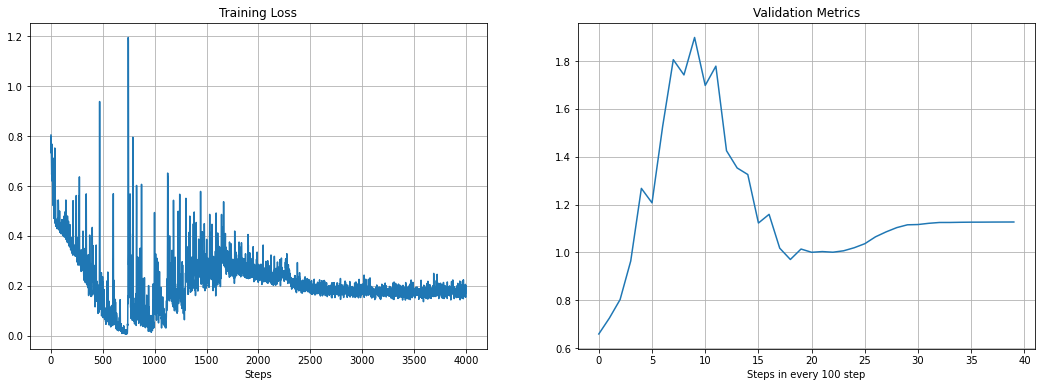

In [186]:
import matplotlib.pyplot as plt

plt.figure(figsize=[18, 6])
plt.subplot(1, 2, 1)
plt.plot(record['train_losses'])
plt.title('Training Loss')
plt.xlabel('Steps')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(record['val_metrics'])
plt.title('Validation Metrics')
plt.xlabel('Steps in every 100 step')
plt.grid()
plt.show()

In [184]:
print(evaluate(y_train, nodegam.predict_proba(pd.DataFrame(x_train, columns=columns))[:,1], task))
print(evaluate(y_val, nodegam.predict_proba(pd.DataFrame(x_val, columns=columns))[:,1], task))
print(evaluate(y_test, nodegam.predict_proba(pd.DataFrame(x_test, columns=columns))[:,1], task))

(0.5067140022971702, 0.3495396468860187)
(0.6502209131075111, 0.5486189123548751)
(0.5337662337662338, 0.4371591468678476)


In [ ]:
# gam_df = nodegam.get_GAM_df(pd.DataFrame(x_test, columns=columns))
gam_df[1:]

- True Negative -> 147
- False Negative -> 73
- True Positive -> 36
- False Positive -> 49

In [ ]:
import plotly.express as px
fig = px.bar(gam_df[1:], y='feat_name', x='importance', orientation='h', range_x=(0, 1.5), text='feat_name', title='Feature importance for nam', height=800, width=800, labels={'importance': 'feature importance'})
fig.update_yaxes(visible=False, showticklabels=False)
fig.update_xaxes(showgrid=False)
fig.show()

In [ ]:
gam_local = get_lr_local_interpretation(147, gam_df['importance'][1:])
fig = plot_local_interpretation(gam_local, 'TRUE NEGATIVE')
fig.show()

In [ ]:
gam_local = get_lr_local_interpretation(73, gam_df['importance'][1:])
fig = plot_local_interpretation(gam_local, 'FALSE NEGATIVE')
fig.show()

In [ ]:
gam_local = get_lr_local_interpretation(36, gam_df['importance'][1:])
fig = plot_local_interpretation(gam_local, 'TRUE POSTIVE')
fig.show()

In [ ]:
gam_local = get_lr_local_interpretation(49, gam_df['importance'][1:])
fig = plot_local_interpretation(gam_local, 'FALSE POSITIVE')
fig.show()

## NODE GA2M

In [187]:
from nodegam.sklearn import NodeGAMClassifier

nodega2m = NodeGAMClassifier(len(columns), validation_size=0.2, ga2m=1, objective='negative_auc', device=device)
nodega2m.fit(pd.DataFrame(x_raw_train, columns=columns), y_raw_train.ravel())

/Users/mtamkeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning:

n_quantiles (2000) is greater than the total number of samples (462). n_quantiles is set to n_samples.

/Users/mtamkeen/opt/anaconda3/lib/python3.9/site-packages/nodegam/odst.py:145: UserWarning:

Data-aware initialization is performed on less than 1000 data points. This may cause instability. To avoid potential problems, run this model on a data batch with at least 1000 data samples. You can do so manually before training. Use with torch.no_grad() for memory efficiency.



Steps	Train Err	Val Metric (negative_auc)
100	0.4352	-0.8143
200	0.3991	-0.833
300	0.3656	-0.8356
400	0.2912	-0.8387
500	0.2529	-0.8533
600	0.1704	-0.8647
700	0.0755	-0.8247
800	0.1233	-0.8065
900	0.0836	-0.7737
1000	0.0611	-0.756
1100	0.0536	-0.7924
1200	0.1097	-0.7893
1300	0.0406	-0.782
1400	0.0352	-0.7633
1500	0.0742	-0.8028
1600	0.04	-0.7971
1700	0.069	-0.8096
1800	0.0391	-0.8122
1900	0.0608	-0.8137
2000	0.0206	-0.8122
2100	0.0186	-0.8137
2200	0.0266	-0.8143
2300	0.0609	-0.8122
LR: 1.00e-02 -> 2.00e-03
2400	0.0078	-0.8091
2500	0.0276	-0.8091
2600	0.0145	-0.808
LR: 2.00e-03 -> 4.00e-04
2700	0.0261	-0.8059
2800	0.0038	-0.8059
2900	0.0068	-0.8059
LR: 4.00e-04 -> 8.00e-05
3000	0.0042	-0.807
3100	0.0017	-0.8059
3200	0.002	-0.8054
LR: 8.00e-05 -> 1.60e-05
3300	0.0122	-0.8065
3400	0.0007	-0.8059
3500	0.0034	-0.8059
LR: 1.60e-05 -> 3.20e-06
3600	0.0052	-0.8059
3700	0.0043	-0.8059
3800	0.0105	-0.8059
LR: 3.20e-06 -> 1.00e-06
3900	0.0069	-0.8059
4000	0.0065	-0.8059
BREAK. There is no improvm

{'train_losses': [0.9910041689872742,
  0.8709344863891602,
  0.838421106338501,
  0.8397914171218872,
  0.8089970350265503,
  0.6550390124320984,
  0.9384423494338989,
  0.7778633832931519,
  0.7312188148498535,
  0.8154478669166565,
  0.7078452110290527,
  0.6473212242126465,
  0.6863653659820557,
  0.6518568992614746,
  0.6230601668357849,
  0.6219117045402527,
  0.597133457660675,
  0.624851405620575,
  0.6135609745979309,
  0.5812520384788513,
  0.6288845539093018,
  0.627913236618042,
  0.6232119798660278,
  0.770376980304718,
  0.6595504283905029,
  0.5272953510284424,
  0.5965749025344849,
  0.560070276260376,
  0.5813604593276978,
  0.5377748012542725,
  0.5612109303474426,
  0.5037850737571716,
  0.5303093791007996,
  0.5177191495895386,
  0.4876803755760193,
  0.48935139179229736,
  0.48979452252388,
  0.49850717186927795,
  0.5027914643287659,
  0.5152856111526489,
  0.5254890322685242,
  0.48428428173065186,
  0.5132638812065125,
  0.46746715903282166,
  0.503861665725708,

In [188]:
evaluate(y_train, nodega2m.predict_proba(pd.DataFrame(x_train, columns=columns))[:,1], task)
evaluate(y_val, nodega2m.predict_proba(pd.DataFrame(x_val, columns=columns))[:,1], task)
evaluate(y_test, nodega2m.predict_proba(pd.DataFrame(x_test, columns=columns))[:,1], task)

(0.5816326530612245, 0.48168698903041757)

In [ ]:
ga2m_df = nodega2m.get_GAM_df(pd.DataFrame(x_test, columns=columns))
ga2m_df

In [ ]:
ga2m_interaction_df = ga2m_df[9:][['feat_name', 'importance']]
ga2m_interaction_df['feat1'] = ga2m_interaction_df['feat_name'].str.split('_').str[0]
ga2m_interaction_df['feat2'] = ga2m_interaction_df['feat_name'].str.split('_').str[1]
ga2m_interaction_df = ga2m_interaction_df.pivot(index='feat1', columns='feat2', values='importance').reindex(columns).T.reindex(columns).fillna(0)
plt.figure(figsize=(20, 15))
dataplot = sns.heatmap(ga2m_interaction_df, annot=False, cmap="Reds")

## HONAM

In [189]:
from model import HONAM
honam = HONAM(
        num_features=x_train.shape[1],
        out_size=1,
        task=task,
        order=2,
        verbose=False,
        lr=0.0001,
        feature_net_dropout=0.5,
        batch_size=200,
        epochs=1000
    ).to(device)
honam.fit(x_train, y_train, x_val, y_val)

In [293]:
print('TRAIN: ', evaluate(y_train, honam.predict(x_train), task))
print('VAL: ', evaluate(y_val, honam.predict(x_val), task))
honam_pred = honam.predict(x_test)
print('TEST: ', evaluate(y_test, honam_pred, task))

TRAIN:  (0.8872715881800146, 0.797565778843382)
VAL:  (0.8608247422680413, 0.7464765263452765)
TEST:  (0.8209647495361782, 0.7121343048845298)


In [225]:
explanation = honam.feature_importance(x_train, columns)
print(explanation.shape)
explanation.head()

(153, 36)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancies*Glucose,Pregnancies*BloodPressure,...,SkinThickness*Insulin,SkinThickness*BMI,SkinThickness*DiabetesPedigreeFunction,SkinThickness*Age,Insulin*BMI,Insulin*DiabetesPedigreeFunction,Insulin*Age,BMI*DiabetesPedigreeFunction,BMI*Age,DiabetesPedigreeFunction*Age
0,0.109572,-0.352666,0.077451,-0.025617,-0.183609,0.077280,-0.065626,0.284658,0.003922,-0.003023,...,-0.010229,0.004126,-0.001188,0.011887,-0.015643,0.010121,0.098537,0.002994,0.012264,0.034250
1,0.064712,-0.007750,-0.081643,-0.022890,-0.069177,0.132487,-0.619767,-0.860355,-0.003119,-0.023639,...,0.001531,0.003839,-0.080728,0.021589,-0.004503,0.051325,0.027318,-0.014601,0.181426,-0.470711
2,0.064712,-0.049876,0.032290,-0.052271,-0.069177,-0.039380,-0.581145,-0.860355,-0.004340,-0.008423,...,-0.003481,0.002649,-0.034836,-0.075280,-0.004356,0.048245,0.027318,-0.008208,-0.018399,-0.439570
3,0.132921,-0.074176,-0.091985,-0.052271,-0.069177,-0.745512,0.102641,0.078688,0.005422,-0.019259,...,-0.003481,-0.022892,0.013638,0.014026,-0.008633,0.015496,0.022953,-0.008219,-0.055318,0.013891
4,0.120720,0.230200,-0.066961,-0.052271,-0.069177,-0.117870,-0.411459,0.371219,-0.012062,-0.028392,...,-0.003481,-0.000024,-0.023578,0.033524,-0.004042,0.034378,0.036510,-0.017717,-0.015411,0.103102


In [250]:
num_samples = 1000
# i=0
cols = []
# X = np.zeros((num_samples, len(columns)))
# X[:, i] = np.linspace(-5.0, 5.0, num_samples)
# df = honam.feature_importance(X, columns)
# df
for i in range(len(columns)):
    X = np.zeros((num_samples, len(columns)))
    X[:, i] = np.linspace(-5.0, 5.0, num_samples)
    df = honam.feature_importance(X, columns)
    cols.append(df.iloc[:,i])
honam_g = pd.DataFrame(cols).T
honam_g

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.362551,-3.971172,0.464243,-1.597519,-2.067227,-4.731299,-1.968216,-1.212199
1,0.361821,-3.962690,0.463236,-1.594484,-2.063138,-4.720988,-1.964299,-1.210297
2,0.361091,-3.954209,0.462229,-1.591450,-2.059049,-4.710678,-1.960382,-1.208396
3,0.360362,-3.945728,0.461221,-1.588416,-2.054960,-4.700367,-1.956465,-1.206494
4,0.359632,-3.937247,0.460214,-1.585382,-2.050872,-4.690057,-1.952548,-1.204593
...,...,...,...,...,...,...,...,...
995,0.892649,3.890187,0.174244,-0.114808,-1.064822,0.993844,0.588708,0.067532
996,0.894643,3.898503,0.174876,-0.114983,-1.067011,0.996021,0.590066,0.066744
997,0.896637,3.906820,0.175507,-0.115158,-1.069201,0.998197,0.591424,0.065956
998,0.898631,3.915136,0.176139,-0.115333,-1.071391,1.000374,0.592783,0.065168


In [254]:
honam_g.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.309070,0.001913,0.115489,-0.456726,-0.788306,-0.869252,-0.376914,-0.306416
std,0.227524,2.215814,0.155157,0.495408,0.539813,1.695740,0.755055,0.546912
min,0.051040,-3.971172,-0.092112,-1.597519,-2.067227,-4.731299,-1.968216,-1.212199
25%,0.133153,-1.853424,-0.013195,-0.843880,-1.065144,-2.187664,-1.002490,-0.804888
50%,0.245252,0.046572,0.094670,-0.112796,-0.711718,0.004737,-0.097198,-0.321900
75%,0.406139,1.855249,0.212241,-0.071243,-0.355090,0.456234,0.250097,0.230630
max,0.900624,3.923453,0.464243,-0.019274,-0.054340,1.002551,0.594141,0.373286


In [253]:
fig = go.Figure()
for col in honam_g.columns:
    fig.add_trace(go.Scatter(x=np.linspace(-5.0, 5.0, num_samples), y=honam_g[col], mode='lines', name=col))
fig.show()

In [318]:
honam_local_test = honam.feature_importance(x_test, columns)
print(honam_local_test.shape)
honam_local_test.head()

(153, 36)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancies*Glucose,Pregnancies*BloodPressure,...,SkinThickness*Insulin,SkinThickness*BMI,SkinThickness*DiabetesPedigreeFunction,SkinThickness*Age,Insulin*BMI,Insulin*DiabetesPedigreeFunction,Insulin*Age,BMI*DiabetesPedigreeFunction,BMI*Age,DiabetesPedigreeFunction*Age
0,0.109572,-0.352666,0.077451,-0.025617,-0.183609,0.077280,-0.065626,0.284658,0.003922,-0.003023,...,-0.010229,0.004126,-0.001188,0.011887,-0.015643,0.010121,0.098537,0.002994,0.012264,0.034250
1,0.064712,-0.007750,-0.081643,-0.022890,-0.069177,0.132487,-0.619767,-0.860355,-0.003119,-0.023639,...,0.001531,0.003839,-0.080728,0.021589,-0.004503,0.051325,0.027318,-0.014601,0.181426,-0.470711
2,0.064712,-0.049876,0.032290,-0.052271,-0.069177,-0.039380,-0.581145,-0.860355,-0.004340,-0.008423,...,-0.003481,0.002649,-0.034836,-0.075280,-0.004356,0.048245,0.027318,-0.008208,-0.018399,-0.439570
3,0.132921,-0.074176,-0.091985,-0.052271,-0.069177,-0.745512,0.102641,0.078688,0.005422,-0.019259,...,-0.003481,-0.022892,0.013638,0.014026,-0.008633,0.015496,0.022953,-0.008219,-0.055318,0.013891
4,0.120720,0.230200,-0.066961,-0.052271,-0.069177,-0.117870,-0.411459,0.371219,-0.012062,-0.028392,...,-0.003481,-0.000024,-0.023578,0.033524,-0.004042,0.034378,0.036510,-0.017717,-0.015411,0.103102


In [360]:
def get_honam_local_interpretation(index, order=1):
    if order == 1:
        _d = honam_local_test.iloc[index, :8]
        _d = _d.reset_index()
        _d.columns = ['variable', 'feature_contribution']
        _d['scaled'] = x_test[index]
        _d['original'] = preprocessor.inverse_transform_x([x_test[index]]).ravel()
        return _d
    elif order == 2:
        _d = honam_local_test.iloc[index, 8:]
        _d = _d.reset_index()
        _d.columns = ['variable', 'feature_contribution']
        _d['feat1'] = _d['variable'].str.split('*').str[0]
        _d['feat2'] = _d['variable'].str.split('*').str[1]
        _d = _d.pivot(index='feat1', columns='feat2', values='feature_contribution').reindex(columns).T.reindex(columns)
        return _d

In [387]:
honam_local_test.iloc[[49, 36, 73, 147], 8:].max().max()

0.4447547197341919

In [355]:
honam_local = get_honam_local_interpretation(147)
fig = plot_local_interpretation(honam_local, f'Local interpretation of Higher-Order NAM for a TRUE NEGATIVE | P(y=1) = {honam_pred[147][0]:.4f}')
fig.show()

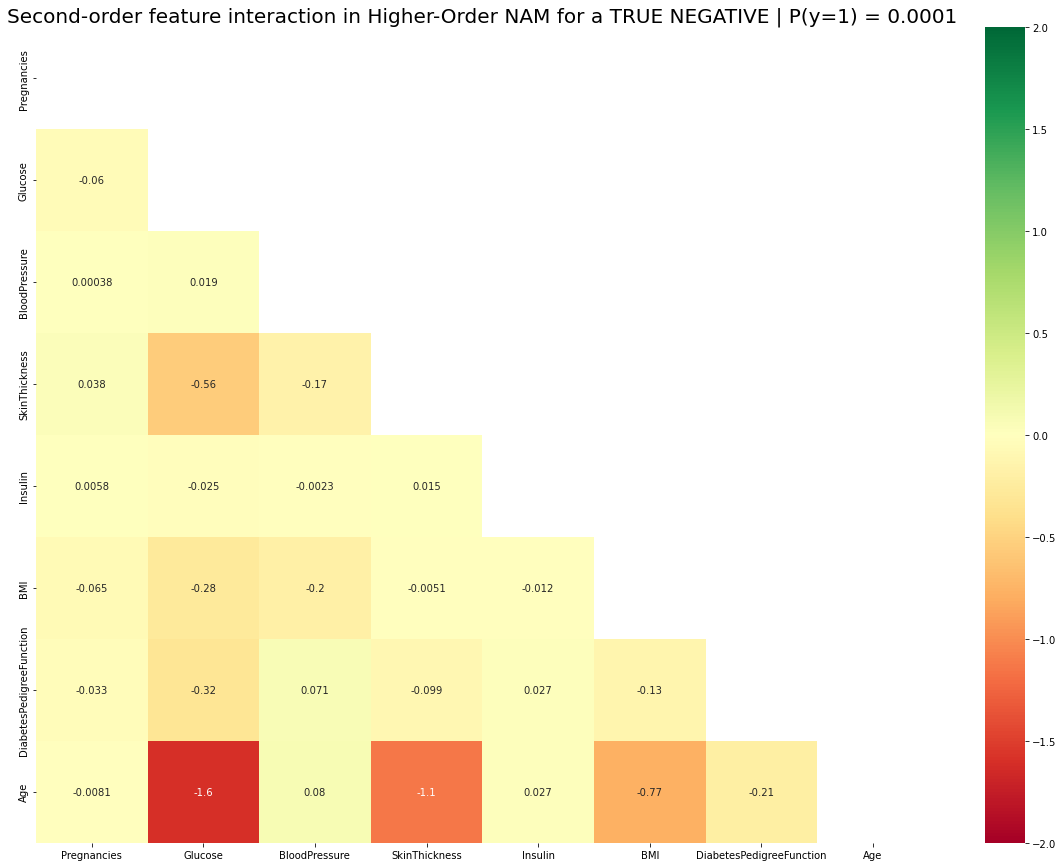

In [389]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 15))
dataplot = sns.heatmap(get_honam_local_interpretation(147, order=2), annot=True, cmap="RdYlGn", vmin=-2, vmax=2)
plt.title(f'Second-order feature interaction in Higher-Order NAM for a TRUE NEGATIVE | P(y=1) = {honam_pred[147][0]:.4f}', fontsize = 20) # title with fontsize 20
plt.xlabel('')
plt.ylabel('')
plt.show()

In [325]:
honam_local = get_honam_local_interpretation(73)
fig = plot_local_interpretation(honam_local, f'Local interpretation of Higher-Order NAM for a FALSE NEGATIVE | P(y=1) = {honam_pred[73][0]:.4f}')
fig.show()

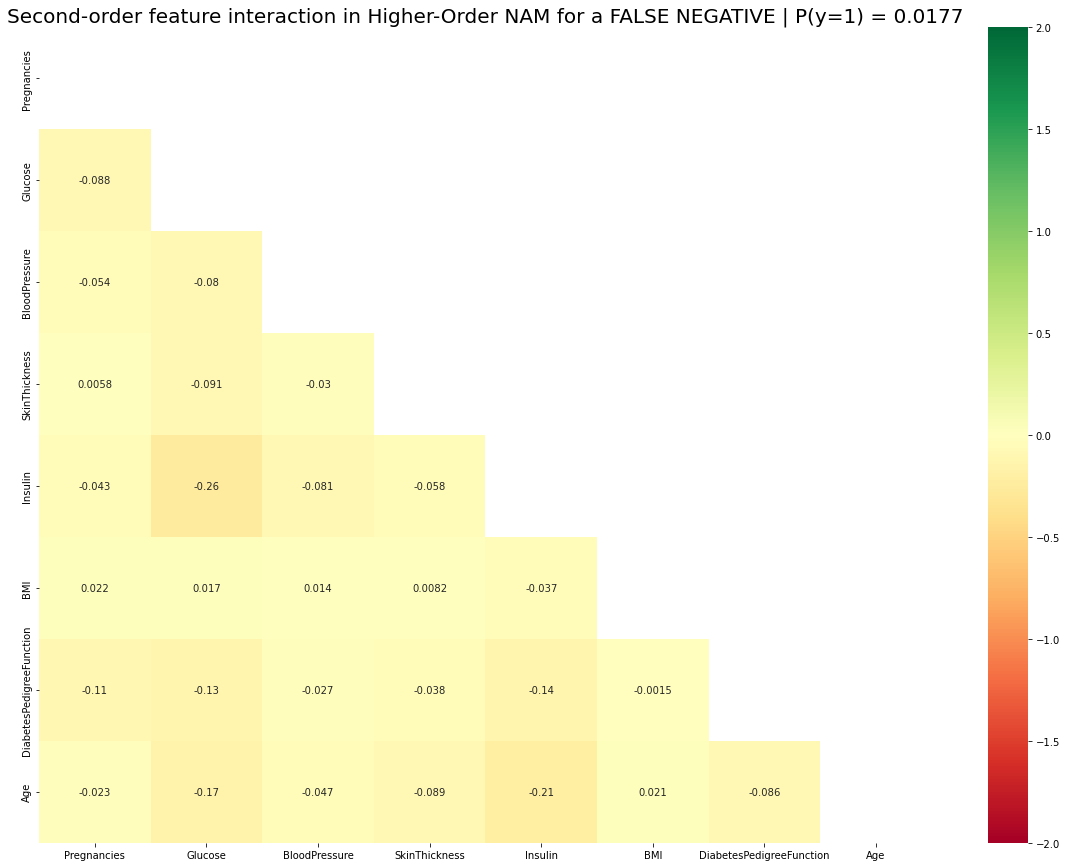

In [390]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 15))
dataplot = sns.heatmap(get_honam_local_interpretation(73, order=2), annot=True, cmap="RdYlGn", vmin=-2, vmax=2)
plt.title(f'Second-order feature interaction in Higher-Order NAM for a FALSE NEGATIVE | P(y=1) = {honam_pred[73][0]:.4f}', fontsize = 20) # title with fontsize 20
plt.xlabel('')
plt.ylabel('')
plt.show()

In [327]:
honam_local = get_honam_local_interpretation(36)
fig = plot_local_interpretation(honam_local, f'Local interpretation of Higher-Order NAM for a TRUE POSITIVE | P(y=1) = {honam_pred[36][0]:.4f}')
fig.show()

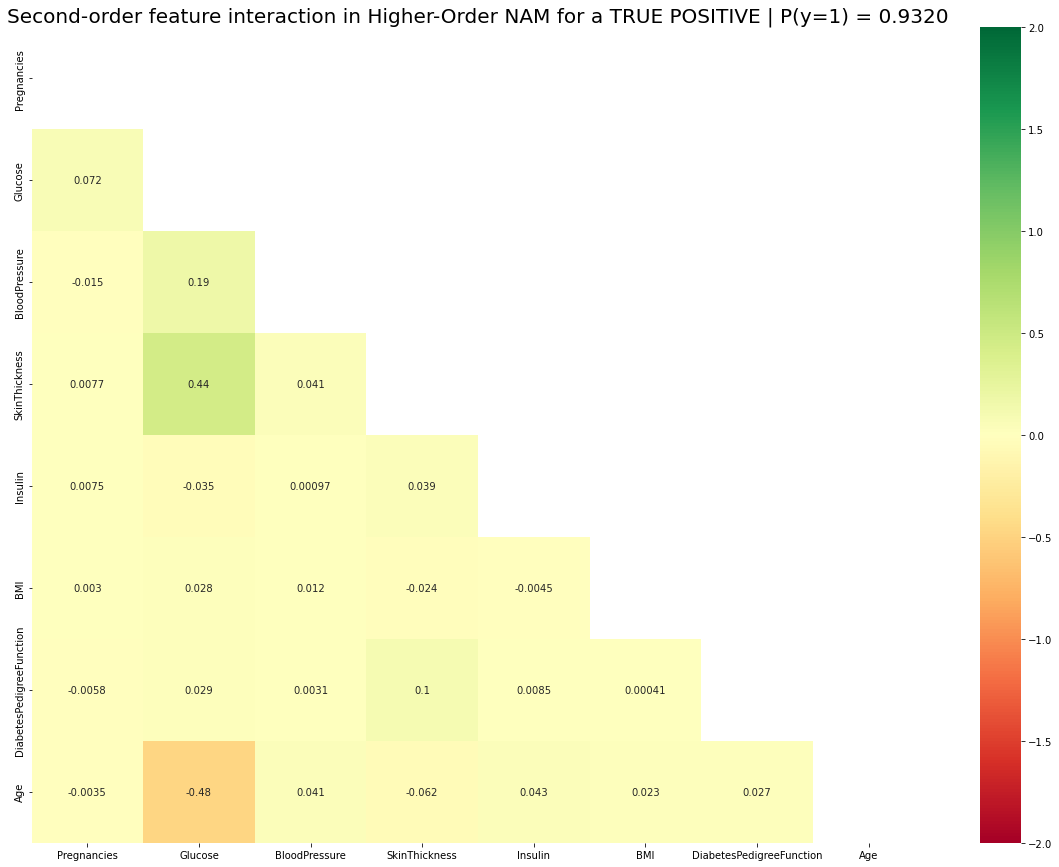

In [391]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 15))
dataplot = sns.heatmap(get_honam_local_interpretation(36, order=2), annot=True, cmap="RdYlGn", vmin=-2, vmax=2)
plt.title(f'Second-order feature interaction in Higher-Order NAM for a TRUE POSITIVE | P(y=1) = {honam_pred[36][0]:.4f}', fontsize = 20) # title with fontsize 20
plt.xlabel('')
plt.ylabel('')
plt.show()

In [328]:
honam_local = get_honam_local_interpretation(49)
fig = plot_local_interpretation(honam_local, f'Local interpretation of Higher-Order NAM for a FALSE POSITIVE | P(y=1) = {honam_pred[49][0]:.4f}')
fig.show()

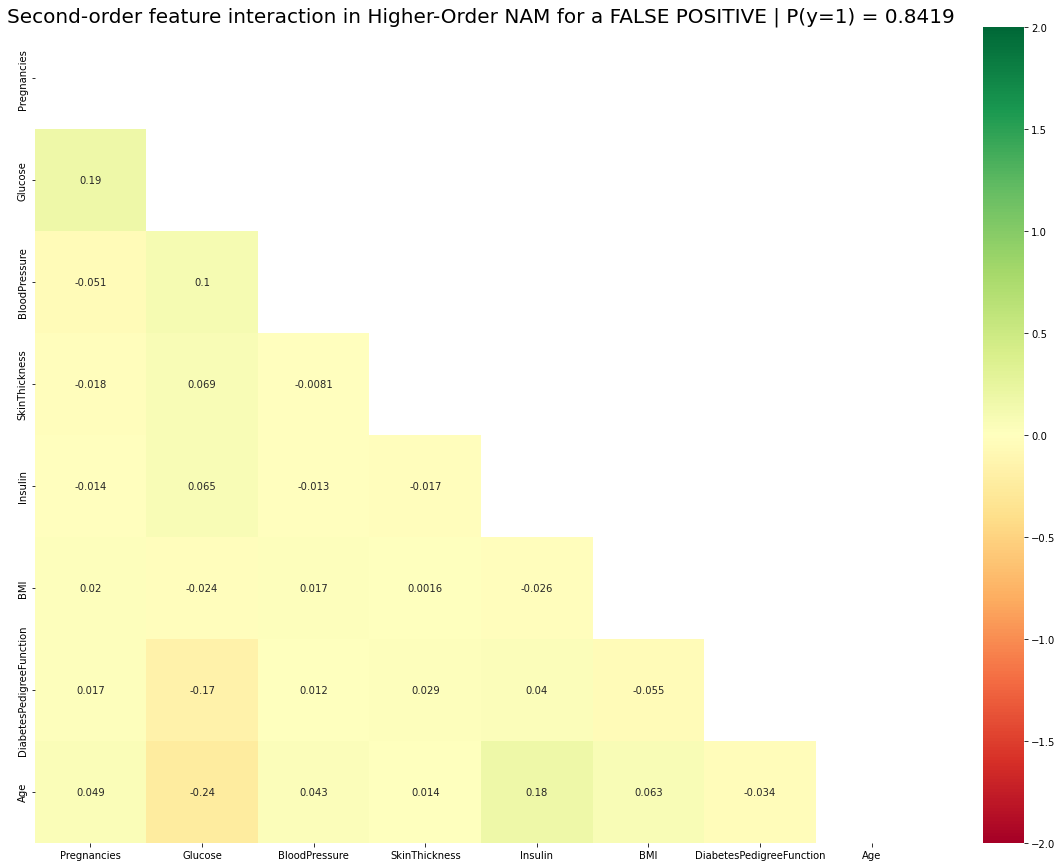

In [392]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 15))
dataplot = sns.heatmap(get_honam_local_interpretation(49, order=2), annot=True, cmap="RdYlGn", vmin=-2, vmax=2)
plt.title(f'Second-order feature interaction in Higher-Order NAM for a FALSE POSITIVE | P(y=1) = {honam_pred[49][0]:.4f}', fontsize = 20) # title with fontsize 20
plt.xlabel('')
plt.ylabel('')
plt.show()

In [ ]:
honam_local = honam.feature_importance(x_test, columns)
honam_global = honam_global.reset_index()
honam_global.columns = ['variable', 'feature_weights']
import plotly.express as px
fig = px.bar(honam_global[:8], y='variable', x='feature_weights', orientation='h', text='variable', title='Global feature importance for Higher-Order Neural Additive Model', height=800, width=800, labels={'feature_weights': 'feature importance'})
fig.update_yaxes(visible=False, showticklabels=False)
fig.update_xaxes(showgrid=False)
fig.show()

In [409]:
from sklearn.metrics import roc_auc_score

def add_roc(name, fig, y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    J = tpr - fpr
    ix = np.argmax(J)
    best_threshold = thresholds[ix]
    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'{name} (AUROC={roc_auc_score(y_true, y_pred):.2f})', legendgroup=name))
#     fig.add_trace(go.Scatter(x=[fpr[ix]], y=[tpr[ix]], mode = 'markers', marker_size = 10, name=name, text=str(best_threshold), showlegend=False, legendgroup=name))

In [418]:
import plotly.graph_objects as go

fig = go.Figure()
add_roc('LR', fig, y_test, lr.predict_proba(x_test)[:, 1])
add_roc('DCN', fig, y_test, dcn.predict(test_model_input).ravel())
add_roc('MLP', fig, y_test, mlp.predict(x_test))
add_roc('XGB', fig, y_test, xgb.predict_proba(x_test)[:, 1])
add_roc('EBM', fig, y_test, ebm.predict_proba(x_test)[:, 1])
add_roc('NAM', fig, y_test, nam.predict_proba(x_test))
# add_roc('NODE GAM', fig, y_test, nodegam.predict_proba(pd.DataFrame(x_test, columns=columns))[:,1])
# add_roc('NODE GA2M', fig, y_test, nodega2m.predict_proba(pd.DataFrame(x_test, columns=columns))[:,1])
add_roc('HONAM', fig, y_test, honam.predict(x_test))

fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], line=dict(dash='dash'), name='Random Classifier (AUROC=0.5)'))

# import plotly.express as px
# colors = [color for color in px.colors.qualitative.Plotly]
# for i in range(0, len(fig.data)-1, 2):
#     color = colors.pop()
#     fig.data[i]['marker']['color'] = color
#     fig.data[i+1]['marker']['color'] = color
# fig.data[len(fig.data)-1]['marker']['color'] = colors.pop()

fig.update_layout(height=1200, width=1200, yaxis=dict(title_text="True positive rate"), xaxis=dict(title_text="False positive rate"), title= 'Receiver operating characteristic on Pima Indians Diabetes Database')

fig.show()

In [416]:
import plotly.graph_objects as go
from sklearn.metrics import average_precision_score, precision_recall_curve

def add_prc(name, fig, y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    fig.add_trace(go.Scatter(x=recall, y=precision, mode='lines', name=f'{name} (AUPRC={average_precision_score(y_true, y_pred):.2f})', legendgroup=name))

In [419]:
fig = go.Figure()
add_prc('LR', fig, y_test, lr.predict_proba(x_test)[:, 1])
add_prc('DCN', fig, y_test, dcn.predict(test_model_input).ravel())
add_prc('MLP', fig, y_test, mlp.predict(x_test))
add_prc('XGB', fig, y_test, xgb.predict_proba(x_test)[:, 1])
add_roc('EBM', fig, y_test, ebm.predict_proba(x_test)[:, 1])
add_prc('NAM', fig, y_test, nam.predict_proba(x_test))
# add_prc('NODE GAM', fig, y_test, nodegam.predict_proba(pd.DataFrame(x_test, columns=columns))[:,1])
# add_prc('NODE GA2M', fig, y_test, nodega2m.predict_proba(pd.DataFrame(x_test, columns=columns))[:,1])
add_prc('HONAM', fig, y_test, honam.predict(x_test))

fig.update_layout(height=1200, width=1200, yaxis=dict(title_text="Precision"), xaxis=dict(title_text="Recall"), title= f'Precision-Recall Curve on Pima Indians Diabetes Database')

fig.show()